In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import os
import re
import seaborn as sns

from scipy import stats
from sklearn import preprocessing
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from functools import reduce
from collections import OrderedDict

# Eksplorasi Data

In [152]:
df_trans = pd.read_csv('/Users/firlisaanggraeni/Documents/Semester 7 (YOK TERAKHIR YOK)/MK/Penambangan Data/Tubes/DMC-2021-Task/transactions.csv')
df_trans.head(10)

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0
5,5,34217,1,0,0
6,6,31436,1,0,0
7,7,14576,1,1,0
8,7,17731,2,1,0
9,8,58723,1,0,0


In [153]:
df_items = pd.read_excel('/Users/firlisaanggraeni/Documents/Semester 7 (YOK TERAKHIR YOK)/MK/Penambangan Data/Tubes/DMC-2021-Task/cleaned.xlsx')
df_items.head(5)

,itemID,title,author,publisher,main_topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"


In [154]:
df_trans.isnull().sum()

sessionID    0
itemID       0
click        0
basket       0
order        0
dtype: int64

In [155]:
df_items.isnull().sum()

itemID           0
title            0
author        3247
publisher        9
main_topic     259
subtopics        0
dtype: int64

In [156]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365143 entries, 0 to 365142
Data columns (total 5 columns):
sessionID    365143 non-null int64
itemID       365143 non-null int64
click        365143 non-null int64
basket       365143 non-null int64
order        365143 non-null int64
dtypes: int64(5)
memory usage: 13.9 MB


In [157]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78334 entries, 0 to 78333
Data columns (total 6 columns):
itemID        78334 non-null int64
title         78334 non-null object
author        75087 non-null object
publisher     78325 non-null object
main_topic    78075 non-null object
subtopics     78334 non-null object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB


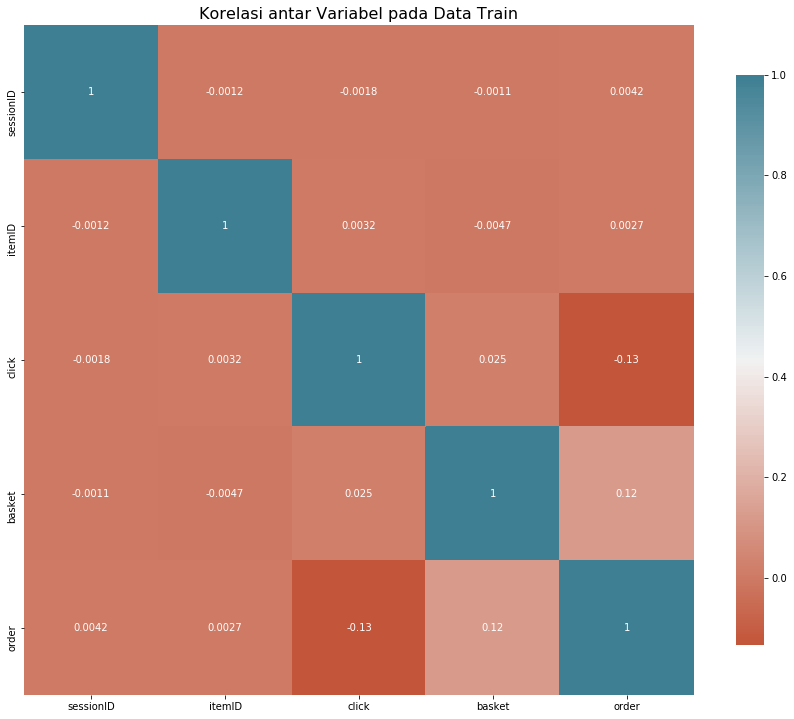

In [158]:
#korelasi antar fitur numeric
corr = df_trans.corr()
f, ax = plt.subplots(figsize=(15,15))
plt.title('Korelasi antar Variabel pada Data Train', y=1, size=16)
ax = sns.heatmap(corr,
                 square=True, 
                 #vmax=0.8,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 annot=True,
                 cbar_kws={'shrink': .7}
                 )

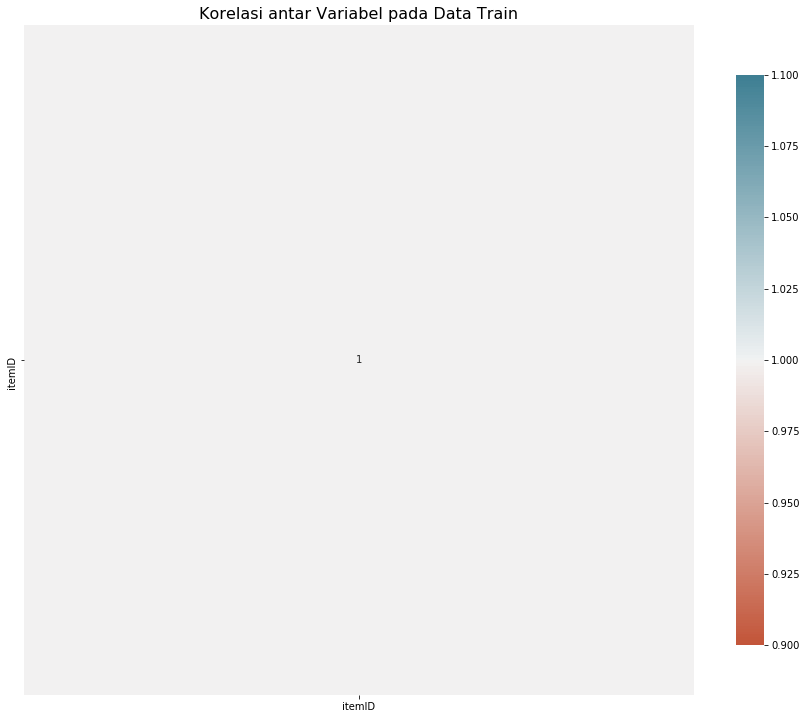

In [159]:
#korelasi antar fitur numeric
corr = df_items.corr()
f, ax = plt.subplots(figsize=(15,15))
plt.title('Korelasi antar Variabel pada Data Train', y=1, size=16)
ax = sns.heatmap(corr,
                 square=True, 
                 #vmax=0.8,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 annot=True,
                 cbar_kws={'shrink': .7}
                 )

# Persiapan Data

In [160]:
#Filling null value
df_items["author"].replace(np.nan, 'Anonymous', inplace=True)
df_items["publisher"].replace(np.nan, '-', inplace=True)
df_items["main_topic"].replace(np.nan, '-', inplace=True)
df_items["itemID"] = df_items["itemID"].astype("str")

In [161]:
temp_null1 = pd.concat([df_items[df_items["author"]=="Anonymous"],df_items[df_items["publisher"]=="-"],df_items[df_items["main_topic"]=="-"]])
temp_null1

,itemID,title,author,publisher,main_topic,subtopics
3,40250,Meine Kindergarten-Freunde (Pirat),Anonymous,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
6,31436,Meine Sticker-Tiere,Anonymous,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]"
10,73124,Freundebuch - Einhorn-Paradies - Meine Freunde,Anonymous,Coppenrath F,YZG,"[5JA,YBG,YBL,YFH,YZS]"
28,63166,Fingerstempel-Spaß Kunterbunt,Anonymous,Ars Edition GmbH,YBLD,"[5AD,YBG,YBLD]"
29,44220,Fingerstempel-Spaß Tiere,Anonymous,Ars Edition GmbH,YBG,"[5AD,YBG,YBLD,YBLL]"
...,...,...,...,...,...,...
64585,44390,Eleha - Aufbruch,Sonja Girisch,Books on Demand,-,[FRM]
76111,21505,Vamps and the City,Kerrelyn Sparks,MIRA Taschenbuch,-,[FMR]
76932,40959,Wie das Schwein zum Tanze ging,Michael Köhlmeier,DTV,-,[5AM]
77565,64864,Die Eingeborenen,Karsten Kruschel,Wurdack,-,"[FLS,FLU]"


In [162]:
df_items.isnull().sum()

itemID        0
title         0
author        0
publisher     0
main_topic    0
subtopics     0
dtype: int64

In [163]:
#Change data type

df_trans["itemID"] = df_trans["itemID"].astype('str')


In [164]:
df_trans = df_trans.loc[df_trans["basket"] >0]
df_trans.reset_index(inplace = True)
df_trans.drop(columns=["index","click","order"], inplace=True)
df_trans

,sessionID,itemID,basket
0,7,14576,1
1,7,17731,1
2,12,29508,1
3,16,15581,1
4,26,23197,1
...,...,...,...
44983,279325,39626,1
44984,279325,33960,2
44985,279333,8703,1
44986,279336,44220,1


In [165]:
temp_trans = df_trans.drop(columns="itemID")
temp_trans = temp_trans.groupby(by=["sessionID"]).sum()
temp_trans.reset_index(inplace=True)
temp_trans
df_trans["basket"] = df_trans["basket"].astype('str')

In [166]:
#Joining value using sessionID
df_trans= df_trans.drop(columns="basket")
df_trans["itemID"] = df_trans.groupby(['sessionID'])['itemID'].transform(
                                              lambda x: ','.join(x))


In [167]:
#drop duplicates
df_trans = df_trans.drop_duplicates() 
df_trans.reset_index(inplace=True)
df_trans.drop(columns="index", inplace=True)
df_trans.drop_duplicates(inplace=True)


In [168]:
df_trans["basket"] = temp_trans["basket"]
df_trans

,sessionID,itemID,basket
0,7,"14576,17731",2
1,12,29508,1
2,16,15581,1
3,26,23197,1
4,28,"57800,11525",2
...,...,...,...
29836,279324,"9133,19324,78761,19070",4
29837,279325,"39626,33960",3
29838,279333,8703,1
29839,279336,44220,1


## Adding target label

In [169]:
#get top 10 
top_10 = df_trans["itemID"].value_counts()
top_10 = top_10.head(10)
top_10 = pd.DataFrame(top_10)
top_10.reset_index(inplace=True)
top_10.columns = ["itemID", "Count"]
top_10

,itemID,Count
0,47120,314
1,23654,291
2,55699,176
3,69803,133
4,58522,112
5,40692,108
6,56174,104
7,39716,100
8,74398,100
9,53695,97


In [170]:
#Labeled data for target label
temp = []
for data in df_trans["itemID"]:
    for top in top_10["itemID"]:
        cek =top in data
        if cek==True:
            temp.append(top)
            break
    if cek == False:
        temp.append("")
        
df_trans["target_class"] = temp
df_trans

,sessionID,itemID,basket,target_class
0,7,"14576,17731",2,
1,12,29508,1,
2,16,15581,1,
3,26,23197,1,
4,28,"57800,11525",2,
...,...,...,...,...
29836,279324,"9133,19324,78761,19070",4,
29837,279325,"39626,33960",3,
29838,279333,8703,1,
29839,279336,44220,1,


In [171]:
df_trans["target_class"].unique()

array(['', '23654', '55699', '69803', '74398', '58522', '40692', '39716',
       '56174', '47120', '53695'], dtype=object)

In [172]:
df_trans["target_class"].replace("", 'Else', inplace=True)
df_trans

,sessionID,itemID,basket,target_class
0,7,"14576,17731",2,Else
1,12,29508,1,Else
2,16,15581,1,Else
3,26,23197,1,Else
4,28,"57800,11525",2,Else
...,...,...,...,...
29836,279324,"9133,19324,78761,19070",4,Else
29837,279325,"39626,33960",3,Else
29838,279333,8703,1,Else
29839,279336,44220,1,Else


# MODELLING

## KLASTERISASI

In [173]:
temp = df_trans["target_class"].values.tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(temp)

In [174]:
n_clusters = 11 
km = KMeans(n_clusters=n_clusters, max_iter=10000, n_init=100, random_state=42).fit(X)
km

KMeans(max_iter=10000, n_clusters=11, n_init=100, random_state=42)

In [175]:
Counter(km.labels_)

Counter({0: 27975,
         2: 377,
         3: 193,
         6: 150,
         7: 135,
         8: 123,
         4: 192,
         10: 105,
         5: 140,
         1: 337,
         9: 114})

In [176]:
df_trans['kmeans_cluster'] = km.labels_

In [179]:
df_trans

,sessionID,itemID,basket,target_class,kmeans_cluster
0,7,"14576,17731",2,Else,0
1,12,29508,1,Else,0
2,16,15581,1,Else,0
3,26,23197,1,Else,0
4,28,"57800,11525",2,Else,0
...,...,...,...,...,...
29836,279324,"9133,19324,78761,19070",4,Else,0
29837,279325,"39626,33960",3,Else,0
29838,279333,8703,1,Else,0
29839,279336,44220,1,Else,0


In [177]:
for j in range(0,11):
    x = []
    temp = df_trans[df_trans["kmeans_cluster"]==j]
    print("=======================")
    print("Cluster ", j+1)
    un = temp["target_class"].unique()[0]
    if un != "Else":
        temp.reset_index(inplace=True)
        temp.drop(columns="index", inplace=True)
        for k in temp["itemID"]:
            text = k
            text = text.split(",")
            x.append(text)

        flatten_list = reduce(lambda z, y :z + y, x)
        count = Counter(flatten_list)
        sorted_dict = OrderedDict(sorted(count.items(), key = lambda kv : kv[1], reverse=True))
        c = 0
        for b in top_10["itemID"]:
            if str(un) == b:
                ind =  top_10.index[top_10["itemID"] == un].tolist()[0]
                print("Top : ", ind+1)
        print("item ID: ", un)
        find = df_items[df_items["itemID"]==un]
        t = df_items.get_value(find.index, 1, takeable = True)[0]
        a = df_items.get_value(find.index, 2, takeable = True)[0]
        print("Title: ",t)
        print("Author: ",a)
        print("")
        print("Since you added ",t, ", to the basket, Here is 5 recommendation books:")
        print("")
        for book in sorted_dict:
            if book != un:
                c+= 1
                if c > 5:
                    break
                find = df_items[df_items["itemID"]==book]
                t_b = df_items.get_value(find.index, 1, takeable = True)[0]
                a_b = df_items.get_value(find.index, 2, takeable = True)[0]
#                 print (c, ". ",book,t_b, " By ",a_b, "has been added to the basket", sorted_dict[book], " times")
                print (c, ". ",book,t_b, " By ",a_b)
                print("")
                
        print("=======================")
    elif un== "Else":
        temp.reset_index(inplace=True)
        temp.drop(columns="index", inplace=True)
        for k in temp["itemID"]:
            text = k
            text = text.split(",")
            x.append(text)

        flatten_list = reduce(lambda z, y :z + y, x)

        count = Counter(flatten_list)
        sorted_dict = OrderedDict(sorted(count.items(), key = lambda kv : kv[1], reverse=True))
        c = 0

        print("Here is 5 random recommendation books based on most added to the basket:")
        print("")
        
        for book in sorted_dict:
            if book != un:
                
                c+= 1
                if c > 5:
                    break
                find = df_items[df_items["itemID"]==book]
                t_b = df_items.get_value(find.index, 1, takeable = True)[0]
                a_b = df_items.get_value(find.index, 2, takeable = True)[0]
                print (c, ". ",book,t_b, " By ",a_b)
                print("")
                
        print("=======================")

Cluster  1
Here is 5 random recommendation books based on most added to the basket:

1 .  46998 Goldene Flammen  By  Leigh Bardugo

2 .  44220 Fingerstempel-Spaß Tiere  By  Anonymous

3 .  3259 Schnippel-Alarm! Das Ausschneidebuch für Kinder ab 3 Jahren  By  Silke Weßner

4 .  42836 Throne of Glass 1 - Die Erwählte  By  Sarah J. Maas

5 .  69185 Die Kunst des Zeichnens für Kinder  By  Gecko Keck

Cluster  2
Top :  1
item ID:  47120
Title:  Wir Kinder vom Bahnhof Zoo
Author:  Kai Hermann, Horst Rieck, Christiane F.

Since you added  Wir Kinder vom Bahnhof Zoo , to the basket, Here is 5 recommendation books:

1 .  3381 Krieg  By  Janne Teller

2 .  74398 ONE OF US IS LYING  By  Karen M. McManus

3 .  33235 Eines Menschen Flügel  By  Andreas Eschbach

4 .  26060 Sofies Welt  By  Jostein Gaarder

5 .  52146 Der Junge im gestreiften Pyjama  By  John Boyne

Cluster  3
Top :  2
item ID:  23654
Title:  Harry Potter 1 und der Stein der Weisen
Author:  Joanne K. Rowling

Since you added  Harry P